<h1><center>[Pytorch] - Global Wheat Detection FASTER R-CNN [EDA - AUGMENTATION - COMPARE MODELS] </center></h1>

***

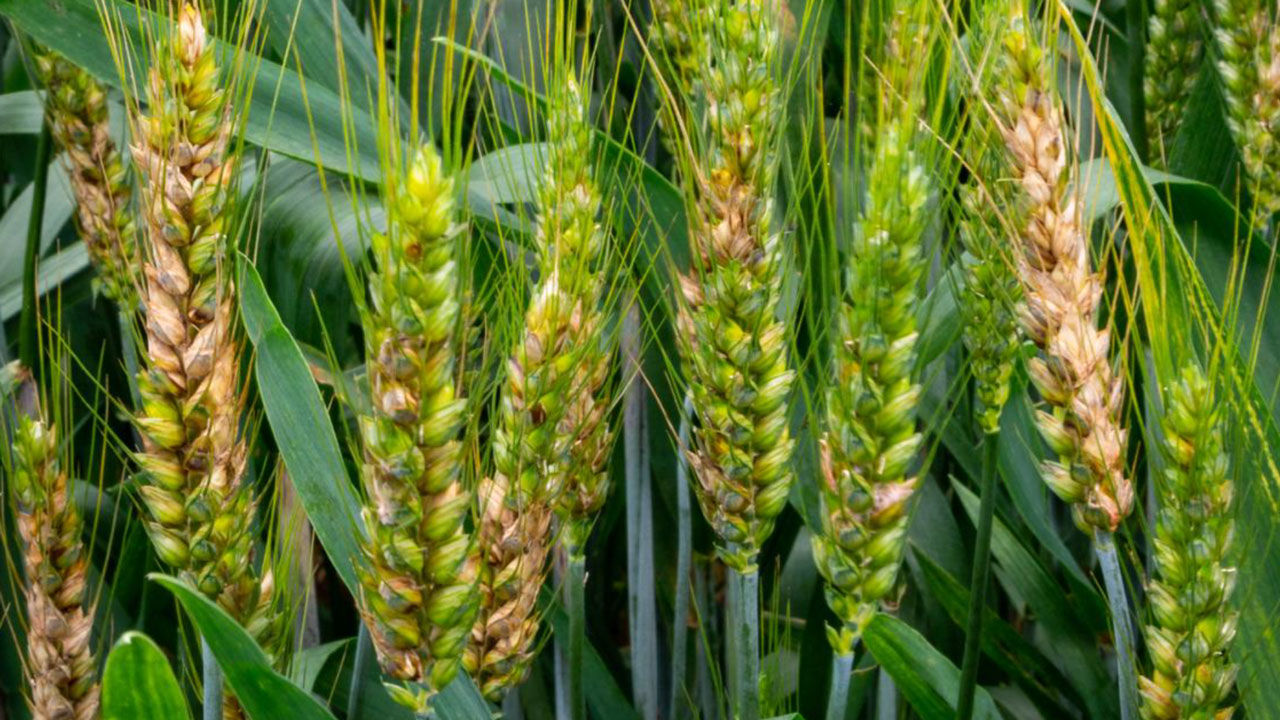

<h1>Introduction</h1>

<p style="text-align:justify;"> In this competition, you’ll detect wheat heads from outdoor images of wheat plants, including wheat datasets from around the globe. Using worldwide data, you will focus on a generalized solution to estimate the number and size of wheat heads. To better gauge the performance for unseen genotypes, environments, and observational conditions, the training dataset covers multiple regions. You will use more than 3,000 images from Europe (France, UK, Switzerland) and North America (Canada). The test data includes about 1,000 images from Australia, Japan, and China.<p/>


***
 <p style="text-align:justify;"> This competition wants us to predict bounding boxes around whaet heads from images of wheat plants, to solve this problem we have a sample of image, and csv file containing the image_id (the unique image ID), the width and height of the images, and bounding box, formatted as a Python-style list of [xmin, ymin, width, height]</p>

***
In this notebook I want to share how to visualize image data with boundary box and some augmentation, then I am going to train data with FasterRCNN resnet50 to solve this problem and compare with difference configuration, if you want to see my other notebook with a different model, [Detectron 2 compare models](http://www.kaggle.com/dhiiyaur/detectron-2-compare-models)


### Change Log

#### V4

> - add new model
> - add  cutout augmentation

#### V3

> - add some information


#### V2

> - add new model (LB score 0.663 --> 0.673)

#### V1

> - add inference
> - add another model to compare
> - change code for train and test

## Import necessary libraries

In [ ]:
import os
import time
import shutil
import random

import numpy as np
import pandas as pd

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from tqdm.notebook import tqdm

import albumentations
from albumentations import *
from albumentations.pytorch.transforms import ToTensorV2
import cv2
import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns
%matplotlib inline
print('Ready...')

## Load Data and Simple EDA

In [ ]:
DATA_DIR  = '../input/global-wheat-detection/train/'
TEST_DIR  = '../input/global-wheat-detection/test/'
train_df_path = '../input/global-wheat-detection/train.csv'
test_df_path = '../input/global-wheat-detection/sample_submission.csv'
List_Data_dir = os.listdir(DATA_DIR)

In [ ]:
raw = pd.read_csv(train_df_path)
raw

let's check if there is empty data

In [ ]:
raw.isnull().any().any()

In [ ]:
raw.info()

Based on the data in the table, it can be seen that there is no empty data, and we can see the data types (Dtype) from each column. let's dig a little deeper


In [ ]:
raw.describe()

Based on the data in the table, we can see there are only two tables (width and height), Why? because from the data we have there are only two columns of type number (Dtype --> number (int/float). From this table, it is known that all our images are 1024 x 1024. Ok, let's see how many that pictures we have

In [ ]:
print(f'Total number of train images: {raw.image_id.nunique()}')
print(f'Total number of test images: {len(os.listdir(TEST_DIR))}')

visualize wheat distribution from source colomn

In [ ]:
plt.figure(figsize=(15,8))
plt.title('Wheat Distribution', fontsize= 20)
sns.countplot(x="source", data=raw)

# based on the chart, there are seven types of wheat from images data, with the most types 'ethz_1' and the least is 'inrae_1'

Let's visualize some image, that we have

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (24, 24))
ax = ax.flatten()
img_path = os.path.join(DATA_DIR, 'b6ab77fd7' + '.jpg')
img_path2 = os.path.join(DATA_DIR, '5e0747034' + '.jpg')

image = cv2.imread(img_path, cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
image /= 255.0
    
ax[0].set_title('Image')
ax[0].imshow(image)
    
image2 = cv2.imread(img_path2, cv2.IMREAD_COLOR)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB).astype(np.float32)
image2 /= 255.0

ax[1].set_title('Image')
ax[1].imshow(image2)

plt.show()

In [ ]:
# Extract bbox column to xmin, ymin, width, height, then create xmax, ymax, and area columns

raw[['xmin','ymin','w','h']] = pd.DataFrame(raw.bbox.str.strip('[]').str.split(',').tolist()).astype(float)
raw['xmax'], raw['ymax'], raw['area'] = raw['xmin'] + raw['w'], raw['ymin'] + raw['h'], raw['w'] * raw['h']
raw.drop(['bbox'], axis=1, inplace= True)
raw

In object detection, we usually use a boundary box to describe the target location. The boundary box is a rectangular box that can be determined by the x and y axis coordinates in the upper-left corner and the x and y axis coordinates in the lower-right corner of the rectangle.

**Let's look at some random images with boundary boxes**

In [ ]:
def show_image(image_id):
    
    fig, ax = plt.subplots(1, 2, figsize = (24, 24))
    ax = ax.flatten()
    
    bbox = raw[raw['image_id'] == image_id ]
    img_path = os.path.join(DATA_DIR, image_id + '.jpg')
    
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0
    image2 = image
    
    ax[0].set_title('Original Image')
    ax[0].imshow(image)
    
    for idx, row in bbox.iterrows():
        x1 = row['xmin']
        y1 = row['ymin']
        x2 = row['xmax']
        y2 = row['ymax']
        label = row['source']
        
        cv2.rectangle(image2, (int(x1),int(y1)), (int(x2),int(y2)), (255,255,255), 2)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(image2, label, (int(x1),int(y1-10)), font, 1, (255,255,255), 2)
    
    ax[1].set_title('Image with Bondary Box')
    ax[1].imshow(image2)

    plt.show()

In [ ]:
show_image(raw.image_id.unique()[91])

In [ ]:
show_image(raw.image_id.unique()[1231])

In [ ]:
show_image(raw.image_id.unique()[3121])

## Augmentations


<p style="text-align:justify;">Data augmentation is a strategy that enables practitioners to significantly increase the diversity of data available for training models, without actually collecting new data. 
In image data, augmentation can range from basic image manipulation like color variation, Fliping, resize, or rotate image, and data augmentation can also reduce overfitting.<p/>

In [ ]:
def get_bboxes(bboxes, col, bbox_format = 'pascal_voc', color='white'):
    for i in range(len(bboxes)):
        x_min = bboxes[i][0]
        y_min = bboxes[i][1]
        x_max = bboxes[i][2]
        y_max = bboxes[i][3]
        width = x_max - x_min
        height = y_max - y_min
        rect = patches.Rectangle((x_min, y_min), 
                                 width, height, 
                                 linewidth=2, 
                                 edgecolor=color, 
                                 facecolor='none')
        col.add_patch(rect)

In [ ]:
def augmented_images(image, augment):
    
    fig, ax = plt.subplots(1, 2, figsize = (24, 24))
    ax = ax.flatten()
    
    image_data = raw[raw['image_id'] == image]
    bbox = image_data[['xmin', 'ymin', 'xmax', 'ymax']].astype(np.int32).values
    labels = np.ones((len(bbox), ))

    image = cv2.imread(os.path.join(DATA_DIR + '/{}.jpg').format(image), cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0
    
    get_bboxes(bbox, ax[0], color='white')
    
    ax[0].set_title('Original Image with Bounding Boxes')
    ax[0].imshow(image)
    
    aug = albumentations.Compose([augment], 
                         bbox_params={'format': 'pascal_voc', 'label_fields':['labels']})

    
    aug_result = aug(image=image, bboxes=bbox, labels=labels)

    aug_image = aug_result['image']
    get_bboxes(aug_result['bboxes'], ax[1], color='red')
    
    ax[1].set_title('Augmented Image with Bounding Boxes')
    ax[1].imshow(aug_image)
    
    plt.show()

In [ ]:
# HorizontalFlip Augmentation
augmented_images(raw.image_id.unique()[1230], albumentations.HorizontalFlip(p=1))

In [ ]:
# VerticalFlip Augmentation
augmented_images(raw.image_id.unique()[2110], albumentations.VerticalFlip(p=1))

In [ ]:
# Change Color to gray
augmented_images(raw.image_id.unique()[1212], albumentations.ToGray(p=1))

In [ ]:
# Random Change Brightness Contrast
augmented_images(raw.image_id.unique()[1230], albumentations.RandomBrightnessContrast(p=1))

In [ ]:
# Random Cutout Image
augmented_images(raw.image_id.unique()[230], albumentations.Cutout(num_holes= random.randint(10, 20), max_h_size= 64, max_w_size =64, p = 1))

## Data Preprocessing (Train Data)

In [ ]:
class wheatdataset_train(Dataset):
       
    def __init__(self, dataframe, data_dir, transforms=None):
        super().__init__()
        self.df = dataframe 
        self.image_list = list(self.df['image_id'].unique())
        self.image_dir = data_dir
        self.transforms = transforms
    
    def __len__(self):
        return len(self.image_list)
        
    def __getitem__(self, idx):
        
        image_id = self.image_list[idx]
        image_data = self.df.loc[self.df['image_id'] == image_id]
        boxes = torch.as_tensor(np.array(image_data[['xmin','ymin','xmax','ymax']]), 
                                dtype=torch.float32)
        area = torch.tensor(np.array(image_data['area']), dtype=torch.int64) 
        labels = torch.ones((image_data.shape[0],), dtype=torch.int64)
        iscrowd = torch.zeros((image_data.shape[0],), dtype=torch.uint8)
         
        target = {}
        target['boxes'] = boxes
        target['area'] = area
        target['labels'] = labels
        target['iscrowd'] = iscrowd
        
        image = cv2.imread((self.image_dir + '/' + image_id + '.jpg'), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        if self.transforms:
            
            image_transforms = {
                                'image': image,
                                'bboxes': target['boxes'],
                                'labels': labels
                                 }
            
            image_transforms = self.transforms(**image_transforms)
            image = image_transforms['image']
            
            target['boxes'] = torch.as_tensor(image_transforms['bboxes'], dtype=torch.float32)
                 
        return image, target

In [ ]:
# Albumentations

def get_train_transform():
    return albumentations.Compose([
        #albumentations.Resize(p=1, height=512, width=512),
        albumentations.ToGray(p=0.5),
        albumentations.Flip(p=0.5),
        albumentations.RandomBrightnessContrast(p=0.5),
        albumentations.Cutout(num_holes= random.randint(10, 20), max_h_size= 64, max_w_size =64, p = 0.40),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


def get_test_transform():
    return albumentations.Compose([
        ToTensorV2(p=1.0)
    ])


def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
train_data = wheatdataset_train(raw, DATA_DIR, get_train_transform())
train_dataloader = DataLoader(train_data, batch_size=16,shuffle=True, num_workers=4,collate_fn=collate_fn)

In [ ]:
len(train_data)

## Create a model and training

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()
print(device)

In [ ]:
def train_model():
    
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    num_classes = 2
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model


In [ ]:
def train(data_loader, epoch):
        
    model = train_model()
    model.train()
    model.to(device)
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    model.parameters


    total_train_loss = []
    itr = 1

    for epoch in tqdm(range(epoch)):
        
        print(f'Epoch :{epoch + 1}')
        start_time = time.time()
        train_loss = []
        
        for images, targets in tqdm(data_loader):
            
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)

            losses = sum(loss for loss in loss_dict.values())
            
            loss_value = losses.item()
            
            train_loss.append(losses.item())
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            
            if itr % 50 == 0:
                print(f"Iteration #{itr} loss: {loss_value:.4f}")

            itr += 1
    
        
        epoch_train_loss = np.mean(train_loss)
        total_train_loss.append(epoch_train_loss)
        print(f'Epoch train loss is {epoch_train_loss:.4f}')
        time_elapsed = time.time() - start_time
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    torch.save(model.state_dict(), 'resnet50_GWD.pth')

    #visualize
    plt.figure(figsize=(12,6))
    plt.title('Train Loss', fontsize= 20)
    plt.plot(total_train_loss)
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.show()

In [ ]:
#train(train_dataloader, num_epochs)

# Inference and Compare Model

## Load test data

In [ ]:
test_df = pd.read_csv(test_df_path)
test_df

<h2>Data Preprocessing (Test Data)</h2>

In [ ]:
class wheatdataset_test(Dataset):
       
    def __init__(self, dataframe, data_dir, transforms=None):
        super().__init__()
        self.df = dataframe 
        self.image_list = list(self.df['image_id'].unique())
        self.image_dir = data_dir
        self.transforms = transforms
    
    def __len__(self):
        return len(self.image_list)
        
    def __getitem__(self, idx):
        
        image_id = self.image_list[idx]
        image_data = self.df.loc[self.df['image_id'] == image_id]  
        image = cv2.imread((self.image_dir + '/' + image_id + '.jpg'), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        if self.transforms:
            
            image_transforms = {
                                'image': image
                                 }
            
            image_transforms = self.transforms(**image_transforms)
            image = image_transforms['image']
                             
        return image, image_id

In [ ]:
test_dataset = wheatdataset_test(test_df, TEST_DIR, get_test_transform())

test_data_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    collate_fn=collate_fn
)

<h2>Inference</h2>

In [ ]:
detection_threshold = 0.3
results = []
color = (255,255,255)
thickness = 2
font = cv2.FONT_HERSHEY_SIMPLEX   

def save_model(model_number):

    MODEL_USE = model_number
    if MODEL_USE == 1:
        MODEL_NAME = 'Faster_RCNN_1'
        WEIGHT_PATH = '../input/global-wheat-detection-model/Faster_RCNN/resnet50_GWD_3.pth'
    elif MODEL_USE == 2:
        MODEL_NAME = 'Faster_RCNN_2'
        WEIGHT_PATH = '../input/global-wheat-detection-model/Faster_RCNN/resnet50_GWD_4.pth'
    elif MODEL_USE == 3:
        MODEL_NAME = 'Faster_RCNN_3'
        WEIGHT_PATH = '../input/global-wheat-detection-model/Faster_RCNN/resnet50_GWD_6.pth'
    elif MODEL_USE == 4:
        MODEL_NAME = 'Faster_RCNN_4'
        WEIGHT_PATH = '../input/global-wheat-detection-model/Faster_RCNN/resnet50_GWD_5.pth'
    elif MODEL_USE == 5:
        MODEL_NAME = 'Faster_RCNN_5'
        WEIGHT_PATH = '../input/global-wheat-detection-model/Faster_RCNN_v2/resnet50_GWD_7.pth'
    elif MODEL_USE == 6:
        MODEL_NAME = 'Faster_RCNN_6'
        WEIGHT_PATH = '../input/gwd-model/resnet50_GWD_9.pth'     

    return MODEL_NAME, WEIGHT_PATH

def test_model():
    
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False,
                                                                 pretrained_backbone=False)
    num_classes = 2
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], 
                                                             j[1][2], j[1][3]))

    return " ".join(pred_strings)

def show_result(data_loader, model_number, color, subs = False):


    MODEL_NAME, WEIGHT_PATH = save_model(model_number)
    model = test_model()
    model.load_state_dict(torch.load(WEIGHT_PATH))
    model.to(device)
    model.eval()
    print(f'Model Name : {MODEL_NAME}')

    for images, image_ids in data_loader:

        images = list(image.to(device) for image in images)
        outputs = model(images)

        for i, image in enumerate(images):

            boxes = outputs[i]['boxes'].data.cpu().numpy()
            scores = outputs[i]['scores'].data.cpu().numpy()
                
            boxes = boxes[scores >= detection_threshold].astype(np.int32)
            scores = scores[scores >= detection_threshold]
            image_id = image_ids[i]
                
            boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

            if subs is True:
                result = {
                          'image_id': image_id,
                          'PredictionString': format_prediction_string(boxes, scores)
                          }
                results.append(result)

            im = cv2.imread('{}/{}.jpg'.format(TEST_DIR, image_id))
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB).astype(np.float32)
            im /= 255.0

            for b,s in zip(boxes,scores):
                cv2.rectangle(im, (b[0],b[1]), (b[0]+b[2],b[1]+b[3]), color, thickness)
                cv2.putText(im, '{:.2}'.format(s), (b[0],b[1]), font, 1, color, thickness)
                        
            plt.figure(figsize=(12,12))
            plt.imshow(im)

## Compare Model

****

### Model 1

> *  Epoch = 10
> *  Flip (p = 0.5)

In [ ]:
show_result(test_data_loader, model_number= 1, color = (0,255,0), subs = False)

### Model 2

> *  Epoch = 10
> *  ToGray (p = 0.5)
> *  Flip (p = 0.5)
> *  RandomBrightnessContrast (p = 0.5)


In [ ]:
show_result(test_data_loader, model_number= 2, color = (255,255,0), subs = False)

### Model 3

> *  Epoch = 20
> *  Flip (p = 0.5)

In [ ]:
show_result(test_data_loader, model_number= 3, color = (255,255,255), subs = False)

### Model 4

> *  Epoch = 20
> *  ToGray (p = 0.5)
> *  Flip (p = 0.5)
> *  RandomBrightnessContrast (p = 0.5)

In [ ]:
show_result(test_data_loader, model_number= 4, color = (255,0,0), subs = False)

### Model 5

> *  Epoch = 35
> *  ToGray (p = 0.5)
> *  Flip (p = 0.5)
> *  RandomBrightnessContrast (p = 0.5)

In [ ]:
show_result(test_data_loader, model_number= 5, color = (255,0,255), subs = False)

### Model 6

> *  Epoch = 45
> *  ToGray (p = 0.5)
> *  Flip (p = 0.5)
> *  RandomBrightnessContrast (p = 0.5)
> *  RandomCutout(num_hole = 10 - 20, size = 64, p = 0.40)

In [ ]:
show_result(test_data_loader, model_number= 6, color = (0, 255, 183), subs = True)

In [ ]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.to_csv('submission.csv', index=False)
test_df

<h3><center>Thank you for reading my notebook, upvote if you like this notebook :)<h3><center>
    
****

## References


EDA - Augmentations

* https://github.com/albumentations-team/albumentations_examples

* https://link.springer.com/article/10.1186/s40537-019-0197-0


Pytorch - Model

* https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
              
* https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-train
 
* https://www.kaggle.com/arunmohan003/fasterrcnn-using-pytorch-baseline